In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import datetime
import glob
import pickle
from datetime import datetime, timedelta
import sys
from scipy.optimize import curve_fit
import random

#import the folder that has the analysis level class
sys.path.append("../CombinedData/")
sys.path.append("../AnalysisTools/")
import Dataset
import AnalysisTools


In [2]:
#common = "/p/lustre2/nexouser/data/StanfordData/angelico/hv-test-chamber/"
common = "../../data/" 
topdirs = {5:"{}Run5/".format(common), 6:"{}Run6/".format(common), 7:"{}Run7/".format(common), 8:"{}Run8/".format(common), 9:"{}Run9/".format(common)}
configs = {5:"../configs/run5_config.yaml", 6:"../configs/run6_config.yaml", 7:"../configs/run7_config.yaml", 8:"../configs/run8_config.yaml", 9:"../configs/run9_config.yaml"}
titles = {5:"SS uncoated", 6:"Refill of SS uncoated", 7:"MgF2 (50nm)", 8:"Pt (50nm)", 9:"MgF2 (20nm)"}
red_file_name = "combined_reduced.p"
#analysis tools objects, unloaded data
anas = {}
for n in topdirs:
    anas[n] = AnalysisTools.AnalysisTools(topdirs[n]+red_file_name, configs[n], title=titles[n], ramp_topdir=topdirs[n])


/Users/linsi/Documents/stanford/HV/ad2-data-processing/notebooks/../AnalysisTools/AnalysisTools.py:127: UserWarning: genfromtxt: Empty input file: "../../data/Run8/ds03/g_events.txt"
  d = np.genfromtxt(os.path.join(root, self.config["g_events_name"]), delimiter=',', dtype=float)


In [3]:
#load data into mem if you want
for n, ana in anas.items():
    if(n == 5 or n == 6): continue
    ana.load_dataframe()

In [4]:
ana = anas[9]
all_light = ana.get_light_triggers()
print("Total light triggers: {:d}".format(len(all_light.index)))
tsep = 50 #seconds from any charge signals
cosmic_light = ana.get_cosmic_triggers(tsep, N=1000)
print("Total cosmic triggers: {:d}".format(len(cosmic_light.index)))

Total light triggers: 199463
On event 0 of 1000
On event 100 of 1000
On event 100 of 1000
On event 100 of 1000
On event 100 of 1000
On event 100 of 1000
On event 100 of 1000
On event 200 of 1000
On event 200 of 1000
On event 200 of 1000
On event 200 of 1000
On event 200 of 1000
On event 200 of 1000
On event 300 of 1000
On event 300 of 1000
On event 400 of 1000
On event 400 of 1000
On event 500 of 1000
On event 600 of 1000
On event 700 of 1000
On event 700 of 1000
On event 700 of 1000
On event 700 of 1000
On event 700 of 1000
On event 700 of 1000
On event 700 of 1000
On event 700 of 1000
On event 700 of 1000
On event 700 of 1000
On event 700 of 1000
On event 700 of 1000
On event 700 of 1000
On event 700 of 1000
On event 700 of 1000
On event 700 of 1000
On event 800 of 1000
On event 800 of 1000
On event 900 of 1000
On event 900 of 1000
On event 900 of 1000
On event 900 of 1000
On event 900 of 1000
On event 900 of 1000
On event 900 of 1000
On event 900 of 1000
On event 900 of 1000
On even

In [5]:
#get waveforms for these events, channels 0 and 1 are PMTs
events = ana.get_waveforms_from_df(cosmic_light, [0, 1])

FileNotFoundError: [Errno 2] No such file or directory: '/p/lustre2/nexouser/data/StanfordData/angelico/hv-test-chamber/Run9/ds11/struck/prereduced_4.p'

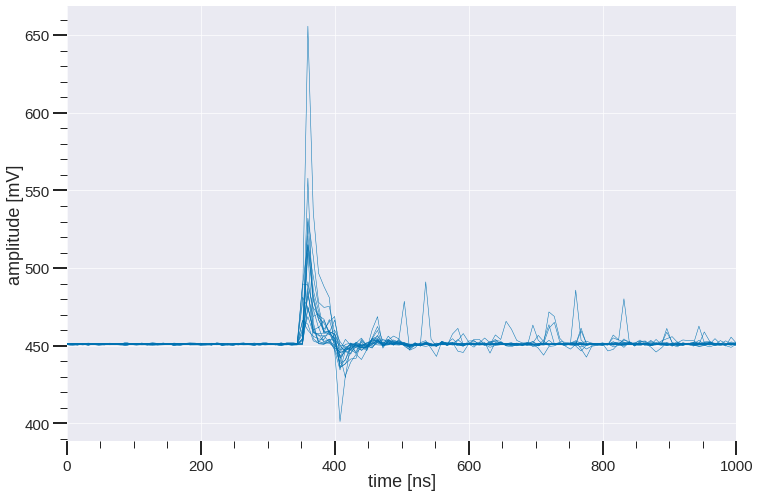

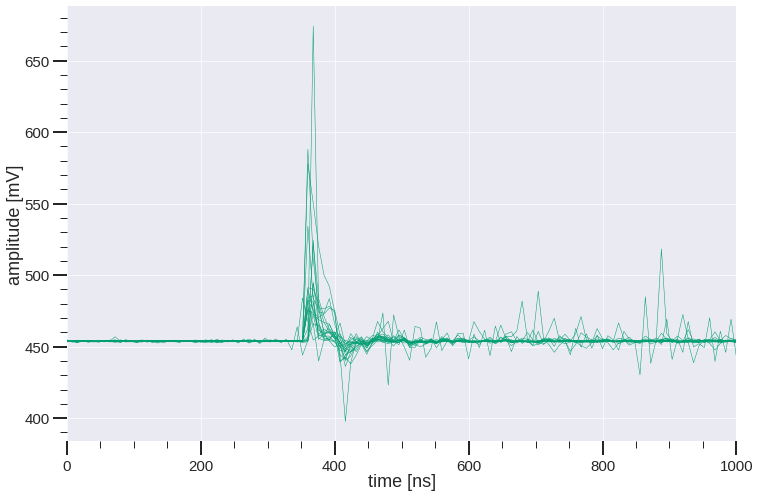

In [16]:
#overlay plot
for ch in [0,1]:
    N_overlay = 20
    evs = random.sample(events[ch], k=N_overlay)
    dT = 1000.0/125 #ns
    fig, ax = plt.subplots()
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for e in evs:
        times = np.arange(0, len(e["Data"])*dT, dT)
        ax.plot(times, e["Data"], color=colors[ch], linewidth=0.5)
    ax.set_xlim([0, 1000])
    ax.set_xlabel("time [ns]")
    ax.set_ylabel("amplitude [mV]")
    plt.show()
    

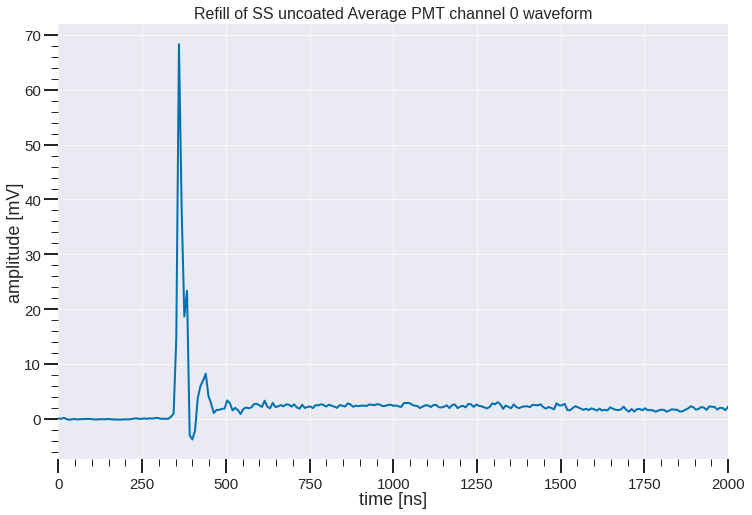

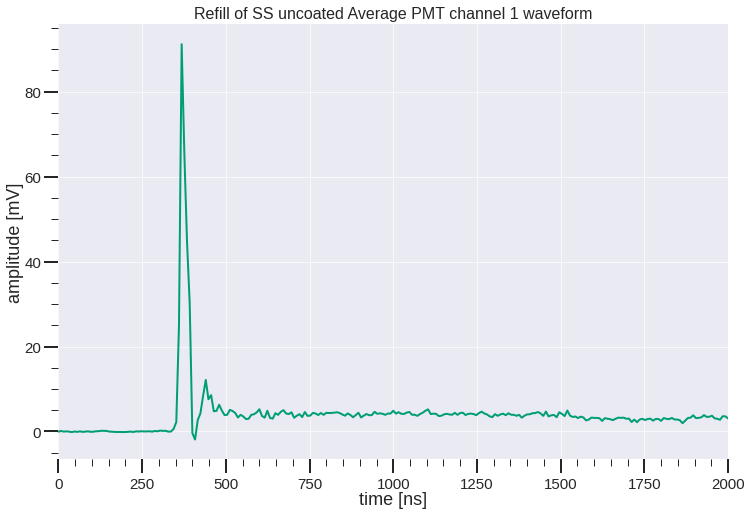

In [36]:
#average waveform plot
bl_wind = ana.config["struck_reduction"]["baseline_window"]

for ch in [0,1]:
    avg_wave = []
    #N_overlay = 200
    #evs = random.sample(events[ch], k=N_overlay)
    evs = events[ch]
    wave_counter = 0
    for e in evs:
        if(len(avg_wave) == 0):
            v = np.array(e["Data"])
            v = v - np.mean(v[bl_wind[0]:bl_wind[1]])
            avg_wave = v
            wave_counter += 1
        elif(len(avg_wave) != len(e["Data"])):
            print("Length mismatch!")
        else:
            v = np.array(e["Data"])
            v = v - np.mean(v[bl_wind[0]:bl_wind[1]])
            avg_wave = avg_wave + v
            wave_counter += 1
            
    avg_wave = avg_wave/wave_counter
    fig, ax = plt.subplots()
    dT = 1000.0/125 #ns
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    times = np.arange(0, len(avg_wave)*dT, dT)
    ax.plot(times, avg_wave, color=colors[ch])
    ax.set_xlim([0, 2000])
    ax.set_xlabel("time [ns]")
    ax.set_ylabel("amplitude [mV]")
    ax.set_title(ana.title + " Average PMT channel {:d} waveform".format(ch))
    plt.show()
    

In [55]:
#Get coincidence with charge events that are negative polar
ana = anas[9]
df = ana.df
thr_mask = (df["ch3 amp"] < -2)


coinc_sec = 0
coinc_ns = 0.4e9 #nanoseconds
charge_ch = 3
coinc_events = ana.get_coincidence(df[thr_mask], charge_ch, coinc_sec, coinc_ns)

In [56]:
#flatten the coinc events into a single DF
coinc_df = pd.concat(coinc_events, ignore_index=True)
#get waveforms for these events, channels 0 and 1 are PMTs
events = ana.get_waveforms_from_df(coinc_df, [0, 1])

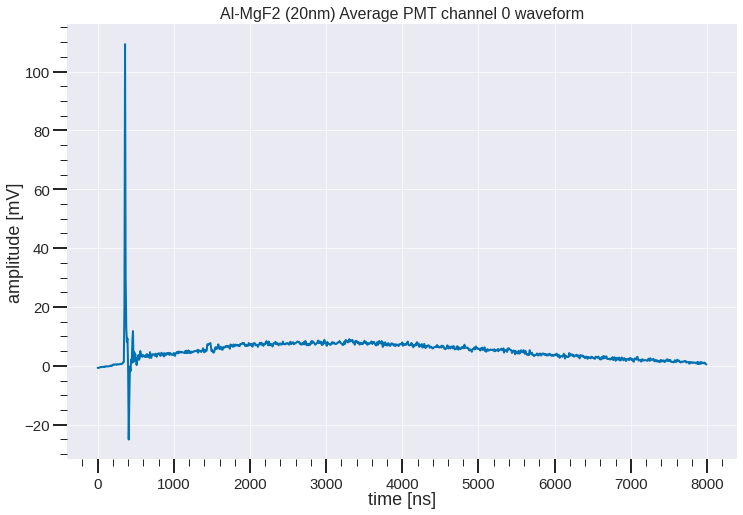

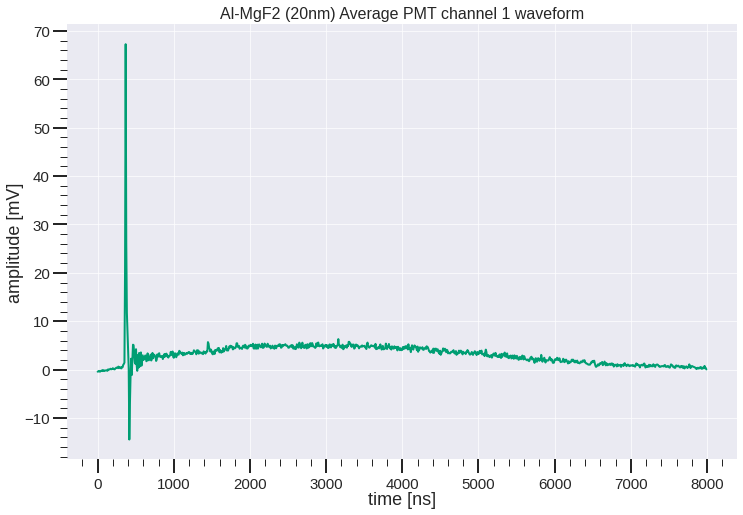

In [63]:
#average waveform plot
bl_wind = ana.config["struck_reduction"]["baseline_window"]

for ch in [0,1]:
    avg_wave = []
    #N_overlay = 200
    #evs = random.sample(events[ch], k=N_overlay)
    evs = events[ch]
    wave_counter = 0
    for e in evs:
        if(len(avg_wave) == 0):
            v = np.array(e["Data"])
            v = v - np.mean(v[bl_wind[0]:bl_wind[1]])
            avg_wave = v
            wave_counter += 1
        elif(len(avg_wave) != len(e["Data"])):
            print("Length mismatch!")
        else:
            v = np.array(e["Data"])
            v = v - np.mean(v[bl_wind[0]:bl_wind[1]])
            avg_wave = avg_wave + v
            wave_counter += 1
            
    avg_wave = avg_wave/wave_counter
    fig, ax = plt.subplots()
    dT = 1000.0/125 #ns
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    times = np.arange(0, len(avg_wave)*dT, dT)
    ax.plot(times, avg_wave, color=colors[ch])
    #ax.set_xlim([0, 2000])
    ax.set_xlabel("time [ns]")
    ax.set_ylabel("amplitude [mV]")
    ax.set_title(ana.title + " Average PMT channel {:d} waveform".format(ch))
    plt.show()
    

950


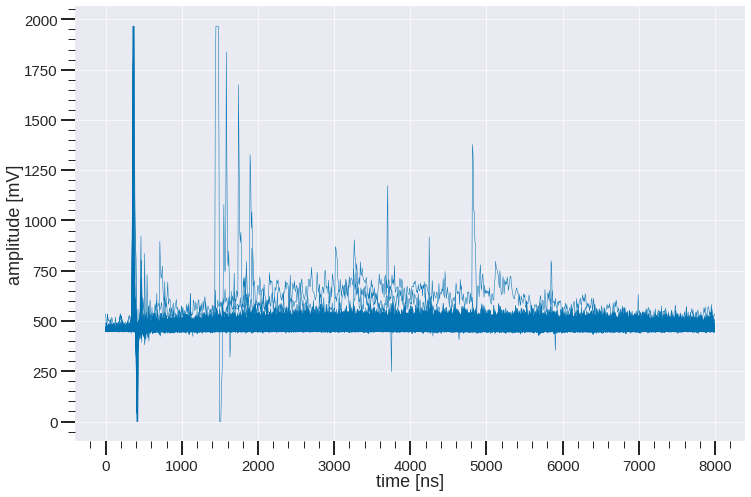

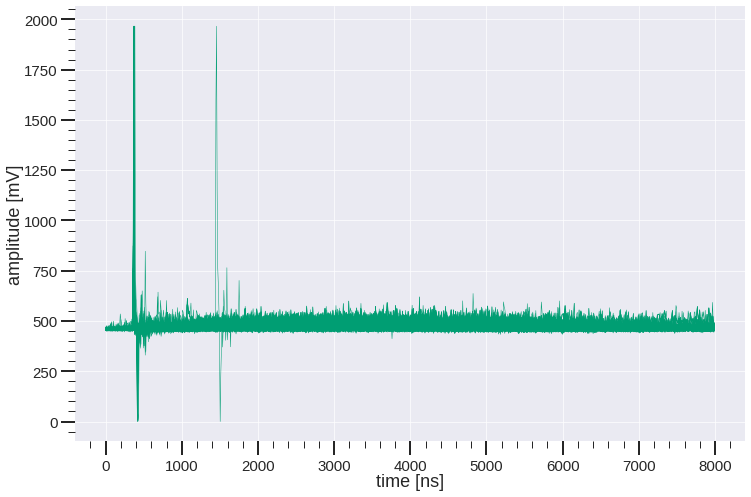

In [62]:
#overlay plot
for ch in [0,1]:
    N_overlay = 900
    evs = random.sample(events[ch], k=N_overlay)
    dT = 1000.0/125 #ns
    fig, ax = plt.subplots()
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for e in evs:
        times = np.arange(0, len(e["Data"])*dT, dT)
        ax.plot(times, e["Data"], color=colors[ch], linewidth=0.5)
    #ax.set_xlim([0, 1000])
    ax.set_xlabel("time [ns]")
    ax.set_ylabel("amplitude [mV]")
    plt.show()
    

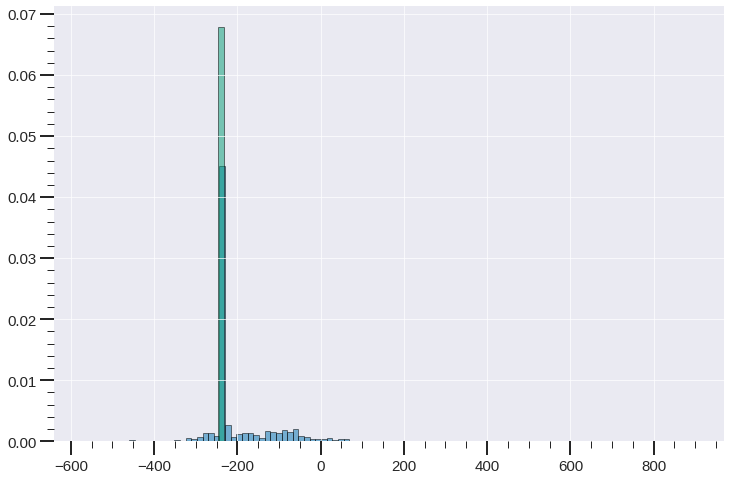

In [79]:
fig, ax = plt.subplots()
ax.hist(np.array(coinc_df["ch0 afterpulse integral"]) - np.array(coinc_df["ch0 baseline"])*8, bins=100, alpha=0.5, density=1)
ax.hist(np.array(ana.df["ch0 afterpulse integral"]) - np.array(ana.df["ch0 baseline"])*8, bins=100, alpha=0.5, density=1)
plt.show()

# Analysis level parameters, distributions

In [6]:
ana = anas[9]
all_light = ana.get_light_triggers()
print("Total light triggers: {:d}".format(len(all_light.index)))
tsep = 50 #seconds from any charge signals
cosmic_light = ana.get_cosmic_triggers(tsep, N=5000)
print("Total cosmic triggers: {:d}".format(len(cosmic_light.index)))

Total light triggers: 199463
On event 0 of 5000
On event 0 of 5000
On event 0 of 5000
On event 0 of 5000
On event 0 of 5000
On event 0 of 5000
On event 100 of 5000
On event 100 of 5000
On event 100 of 5000
On event 200 of 5000
On event 200 of 5000
On event 300 of 5000
On event 300 of 5000
On event 300 of 5000
On event 300 of 5000
On event 300 of 5000
On event 400 of 5000
On event 500 of 5000
On event 500 of 5000
On event 500 of 5000
On event 500 of 5000
On event 500 of 5000
On event 600 of 5000
On event 600 of 5000
On event 600 of 5000
On event 600 of 5000
On event 700 of 5000
On event 700 of 5000
On event 700 of 5000
On event 700 of 5000
On event 700 of 5000
On event 700 of 5000
On event 700 of 5000
On event 800 of 5000
On event 900 of 5000
On event 1000 of 5000
On event 1000 of 5000
On event 1000 of 5000
On event 1100 of 5000
On event 1100 of 5000
On event 1100 of 5000
On event 1100 of 5000
On event 1100 of 5000
On event 1200 of 5000
On event 1300 of 5000
On event 1300 of 5000
On eve

In [7]:
#summed amplitude and integrals from both channels. Its a bit
#complicated due to the baseline
pmt_amps = []
pmt_integrals = []
for i, row in cosmic_light.iterrows():
    if(np.isnan(row["ch0 amp"]) == False):
        #it is on the todo list to make these hard-coded integration bound times NOT hard coded... in Dataset.py level 
        #Also, the baseline is not being reconstructed well and biases the integral heavily. I'm going to use a mean of the
        #postbaseline and the baseline here. 

        #ch0
        bl = np.mean([row["ch0 baseline"], np.mean(row["ch0 postbaseline"])])
        ch0_int = row["ch0 afterpulse integral"] - 7.48*bl + row["ch0 trigger integral"] - 0.16*bl
        ch0_amp = row["ch0 amp"] - bl

        #ch 1
        bl = np.mean([row["ch1 baseline"], np.mean(row["ch1 postbaseline"])])
        ch1_int = row["ch1 afterpulse integral"] - 7.48*bl + row["ch1 trigger integral"] - 0.16*bl
        ch1_amp = row["ch1 amp"] - bl


        pmt_integrals.append(ch0_int + ch1_int)
        pmt_amps.append(ch1_amp + ch0_amp)


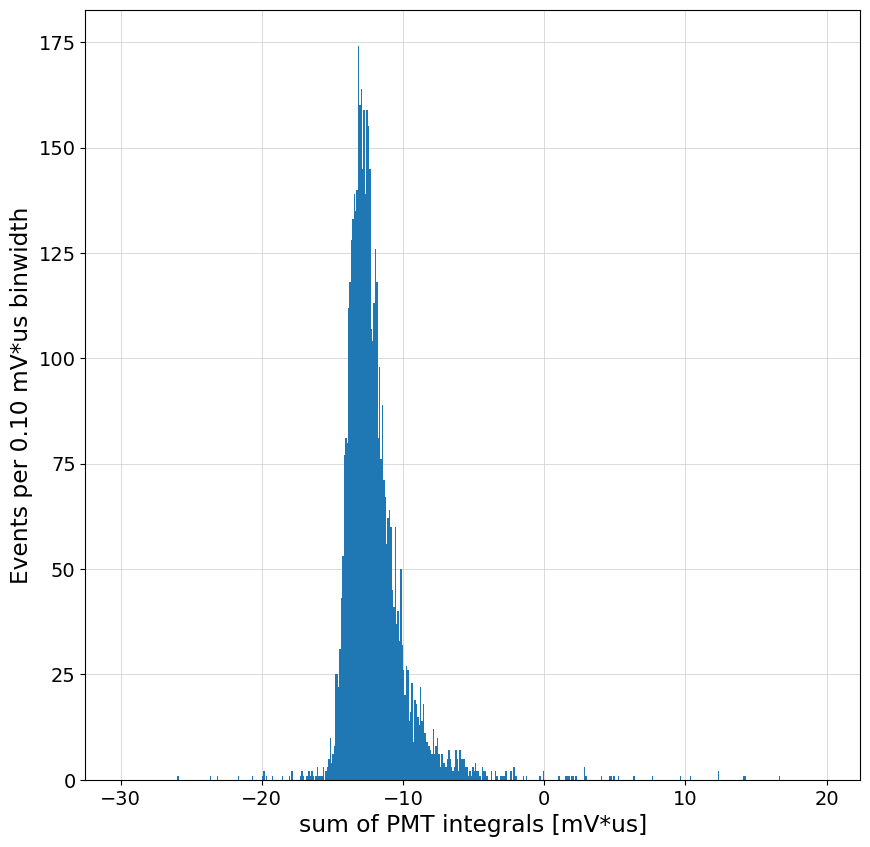

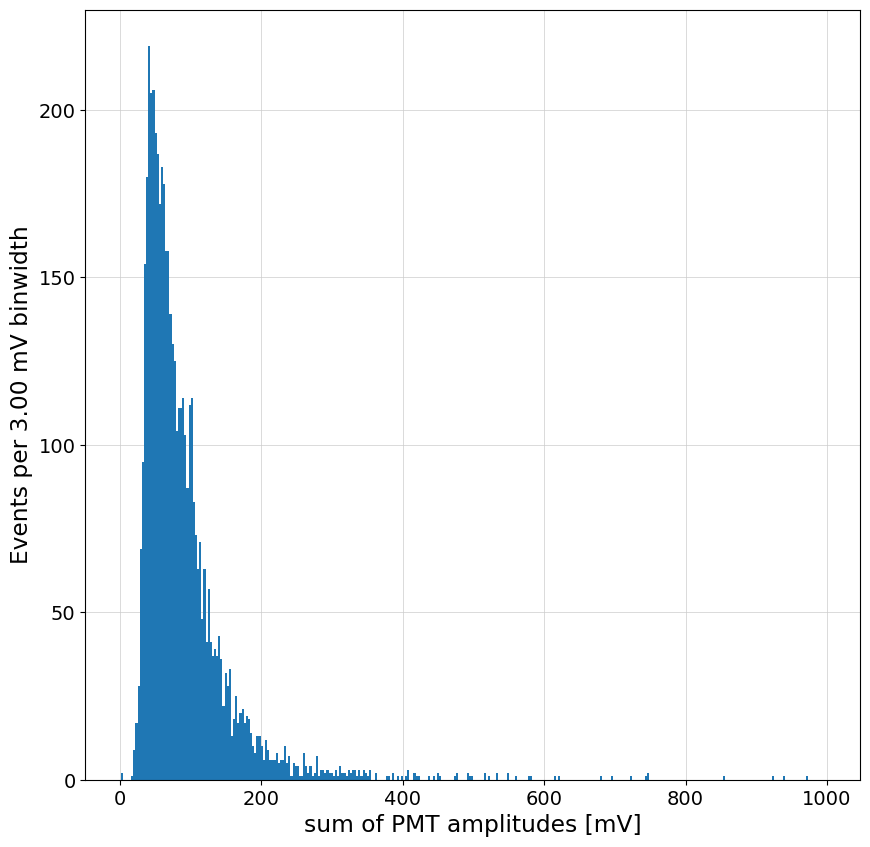

In [8]:
fig, ax = plt.subplots()
binwidth = 0.1 #mV*us
bins = np.arange(-30, 20, binwidth)
ax.hist(pmt_integrals, bins=bins)
ax.set_ylabel("Events per {:0.2f} mV*us binwidth".format(binwidth))
ax.set_xlabel("sum of PMT integrals [mV*us]")
plt.show()

fig, ax = plt.subplots()
binwidth = 3 #mV
bins = np.arange(np.min(pmt_amps), 1000, binwidth)
ax.hist(pmt_amps, bins=bins)
ax.set_ylabel("Events per {:0.2f} mV binwidth".format(binwidth))
ax.set_xlabel("sum of PMT amplitudes [mV]")
plt.show()


#save data to pickle
pickle.dump([pmt_amps, pmt_integrals], open("../../data/Run9/cosmic_pmt_properties.p", "wb"))

# Poisson statistics

In [9]:
ana = anas[9]
all_light = ana.get_light_triggers()
print("Total light triggers: {:d}".format(len(all_light.index)))
tsep = 50 #seconds from any charge signals
cosmic_light = ana.get_cosmic_triggers(tsep, N=10000)
print("Total cosmic triggers: {:d}".format(len(cosmic_light.index)))

Total light triggers: 199463
On event 0 of 10000
On event 0 of 10000
On event 100 of 10000
On event 200 of 10000
On event 200 of 10000
On event 200 of 10000
On event 200 of 10000
On event 200 of 10000
On event 200 of 10000
On event 200 of 10000
On event 200 of 10000
On event 300 of 10000
On event 300 of 10000
On event 300 of 10000
On event 300 of 10000
On event 400 of 10000
On event 400 of 10000
On event 400 of 10000
On event 400 of 10000
On event 500 of 10000
On event 500 of 10000
On event 500 of 10000
On event 500 of 10000
On event 600 of 10000
On event 600 of 10000
On event 600 of 10000
On event 700 of 10000
On event 700 of 10000
On event 800 of 10000
On event 800 of 10000
On event 800 of 10000
On event 800 of 10000
On event 800 of 10000
On event 800 of 10000
On event 800 of 10000
On event 800 of 10000
On event 800 of 10000
On event 800 of 10000
On event 800 of 10000
On event 800 of 10000
On event 800 of 10000
On event 800 of 10000
On event 800 of 10000
On event 800 of 10000
On even

On event 8000 of 10000
On event 8000 of 10000
On event 8100 of 10000
On event 8200 of 10000
On event 8200 of 10000
On event 8300 of 10000
On event 8400 of 10000
On event 8400 of 10000
On event 8500 of 10000
On event 8500 of 10000
On event 8500 of 10000
On event 8600 of 10000
On event 8600 of 10000
On event 8600 of 10000
On event 8600 of 10000
On event 8700 of 10000
On event 8700 of 10000
On event 8700 of 10000
On event 8700 of 10000
On event 8700 of 10000
On event 8800 of 10000
On event 8800 of 10000
On event 8800 of 10000
On event 8800 of 10000
On event 8800 of 10000
On event 8800 of 10000
On event 8800 of 10000
On event 8800 of 10000
On event 8800 of 10000
On event 8800 of 10000
On event 8800 of 10000
On event 8800 of 10000
On event 8800 of 10000
On event 8800 of 10000
On event 8800 of 10000
On event 8800 of 10000
On event 8800 of 10000
On event 8800 of 10000
On event 8800 of 10000
On event 8900 of 10000
On event 9000 of 10000
On event 9000 of 10000
On event 9000 of 10000
On event 90

In [10]:
min_t_sec = np.min(cosmic_light["ch0 seconds"]) #to be able to do easier time computations in the nanoseconds regime
cosmic_light["ch0 tzerod"] = (cosmic_light["ch0 seconds"] - min_t_sec) + cosmic_light["ch0 nanoseconds"]/1e9
cosmic_light = cosmic_light.sort_values(by="ch0 tzerod")
dTs = []
#there are breaks in the data, where either the dataset 
#is changed over or there are charge events. this is the cutoff for including
#the time difference in the list
time_thresh = 50 #seconds
last_t = None
for i, (_, row) in enumerate(cosmic_light.iterrows()):
    if(i == 0): 
        last_t = row["ch0 tzerod"]
        continue
    dt = row["ch0 tzerod"] - last_t
    if(dt <= time_thresh):
        dTs.append(dt)
    last_t = row["ch0 tzerod"]


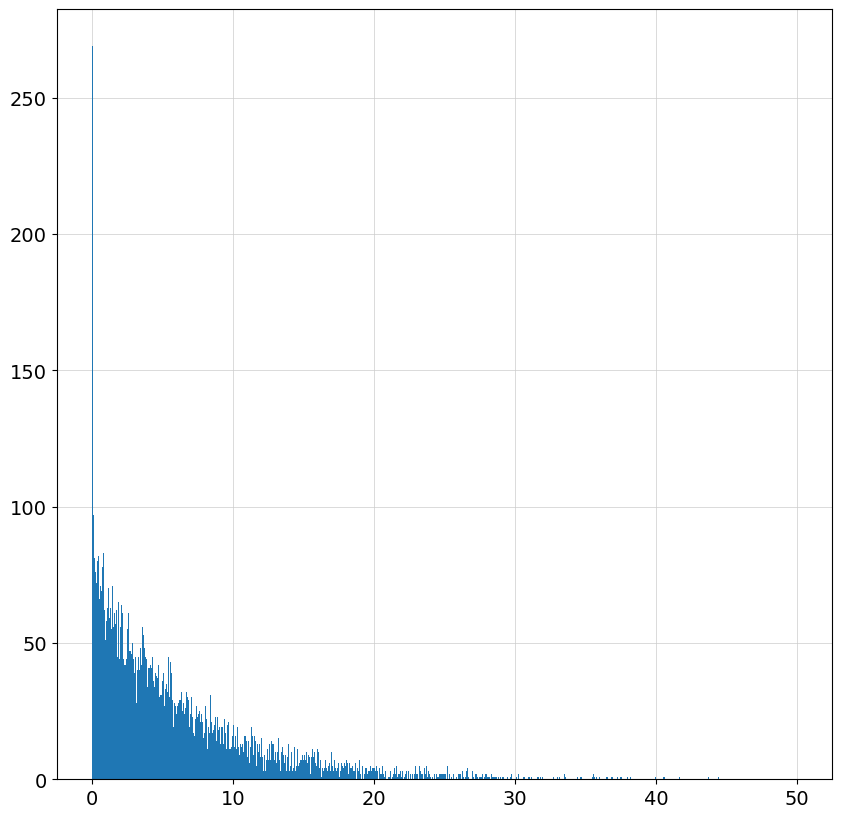

In [11]:
fig, ax = plt.subplots()
binwidth = 0.05
bins = np.arange(0, time_thresh, binwidth)
ax.hist(dTs, bins=bins)
plt.show()

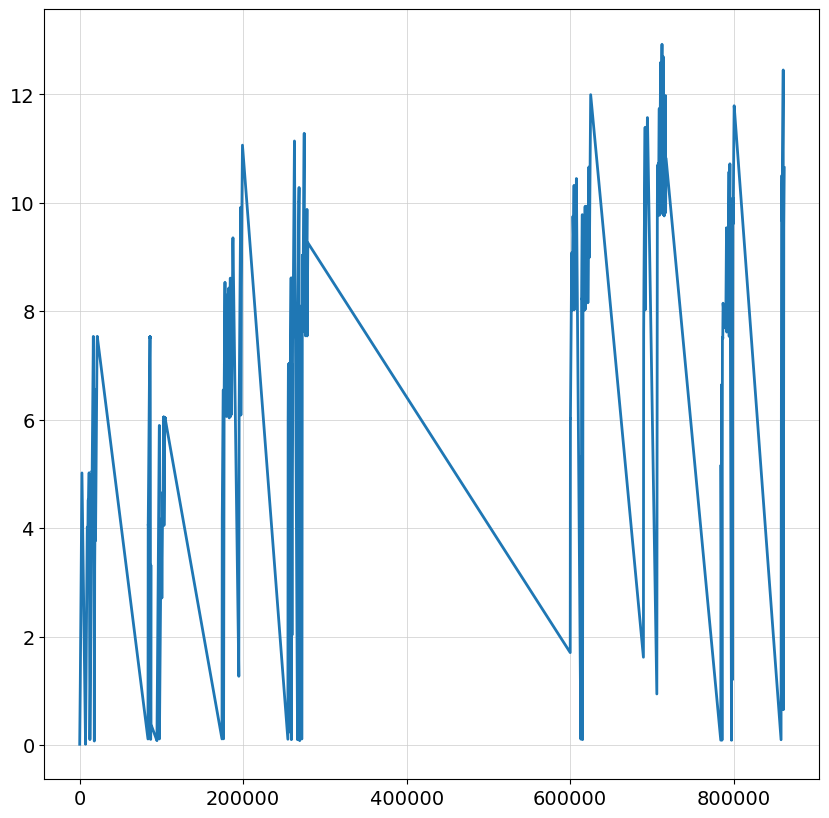

In [12]:
fig, ax = plt.subplots()
ax.plot(cosmic_light["ch0 tzerod"], cosmic_light["ch0 hv"])

plt.show()

In [19]:
df7 = pickle.load(open("../../data/Run7/cosmics-endofrun/reduced.p", "rb"))[0]

In [20]:
min_t_sec = np.min(df7["ch0 seconds"]) #to be able to do easier time computations in the nanoseconds regime
df7["ch0 tzerod"] = (df7["ch0 seconds"] - min_t_sec) + df7["ch0 nanoseconds"]/1e9
df7 = df7.sort_values(by="ch0 tzerod")
dTs = []
#there are breaks in the data, where either the dataset 
#is changed over or there are charge events. this is the cutoff for including
#the time difference in the list
time_thresh = 50 #seconds
last_t = None
for i, (_, row) in enumerate(df7.iterrows()):
    if(i == 0): 
        last_t = row["ch0 tzerod"]
        continue
    dt = row["ch0 tzerod"] - last_t
    if(dt <= time_thresh):
        dTs.append(dt)
    last_t = row["ch0 tzerod"]

normed_event_times = [0]
for i in range(len(dTs)):
    normed_event_times.append(normed_event_times[-1] + dTs[i])

dur = 10 #seconds
inter = [0, dur]
nev = []
while True:
    if(inter[1] > np.max(normed_event_times)):
        break
    #get index of closest value to lower interval bound
    idx = np.argmin(np.abs(np.array(normed_event_times) - inter[0]))
    count = 0
    while True:
        if(normed_event_times[idx] > inter[1]):
            break
        count += 1
        idx += 1
    nev.append(count)

    inter[0] += dur
    inter[1] += dur




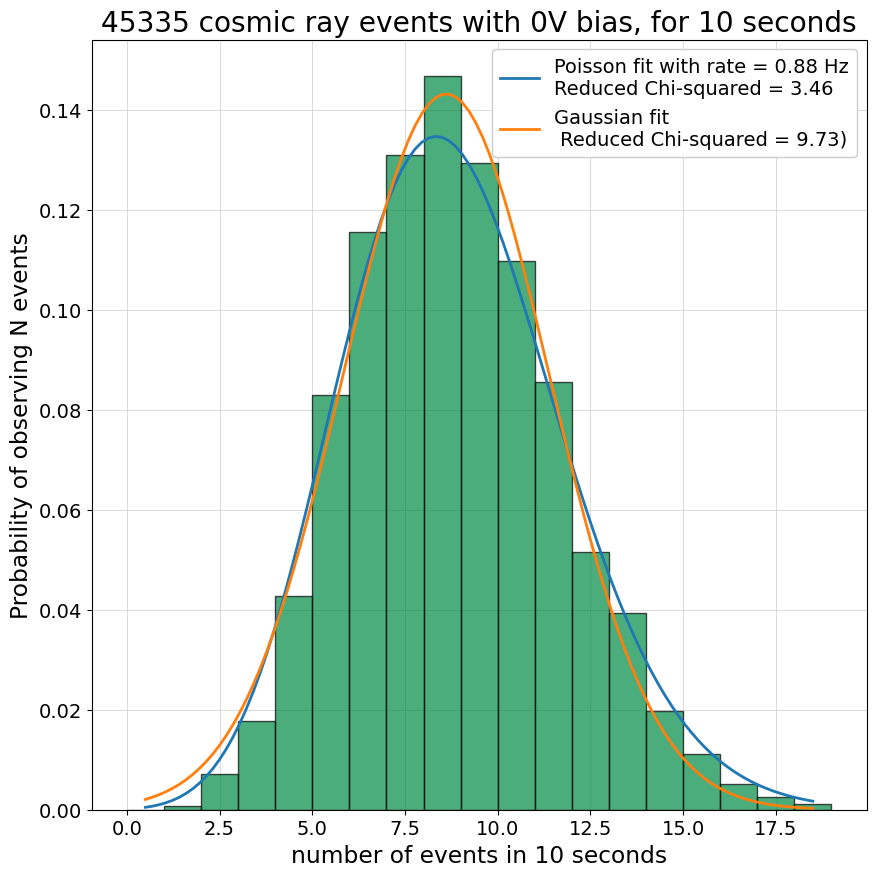

In [47]:
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.special import loggamma

#numerically stable poisson distribution 
def fitfunc(k, lam):
    return np.exp(k*np.log(lam) - lam - loggamma(k+1))

# Function for fitting Gaussian
def gaussian_fit(k, mu, sigma):
    return norm.pdf(k, loc=mu, scale=sigma)
# Fit Gaussian distribution to the original data
gaussian_popt, _ = curve_fit(lambda x, mu, sigma: gaussian_fit(x, mu, sigma), bin_centers, n, p0=[np.mean(nev), np.std(nev)])



fig, ax = plt.subplots()


bins = range(int(2*dur)) #number of events in dur seconds
n, bins, patches = ax.hist(nev, bins=bins, density=True, alpha=0.7, color='#008B45', edgecolor='black')
bin_centers = 0.5*(bins[1:] + bins[:-1])

popt, pcov = curve_fit(fitfunc, bin_centers, n, p0=[np.mean(nev)])

fitx = np.linspace(np.min(bin_centers), np.max(bin_centers), 100)
fity = fitfunc(fitx, *popt)
red_x2 = 0 
ndf = len(bin_centers) - 1
for i in range(len(n)):
    fitval = fitfunc(bin_centers[i], *popt)
    red_x2 += len(nev)*(n[i] - fitval)**2/fitval/ndf

# Recreate the Gaussian distribution fit
gaussian_fitx = np.linspace(np.min(bin_centers), np.max(bin_centers), 100)
gaussian_fity = gaussian_fit(gaussian_fitx, gaussian_popt[0], gaussian_popt[1])

# Calculate reduced chi-squared for Gaussian
red_x2_gaussian = 0
for i in range(len(n)):
    fitval = gaussian_fit(bin_centers[i], gaussian_popt[0], gaussian_popt[1])
    red_x2_gaussian += len(nev) * (n[i] - fitval) ** 2 / fitval / ndf
   
    
#ax.plot(fitx, fity, label="Poisson with rate = {:0.2f} Hz\n".format(popt[0]/dur))#+ r"$\chi^2$/{:d} = {:.2f}".format(ndf, red_x2))
ax.plot(fitx, fity, label=f"Poisson fit with rate = {popt[0] / dur:.2f} Hz\nReduced Chi-squared = {red_x2:.2f}")
ax.plot(gaussian_fitx, gaussian_fity, label=f"Gaussian fit\n Reduced Chi-squared = {red_x2_gaussian:.2f})")


ax.set_title("{:d} cosmic ray events with 0V bias, for {:0.0f} seconds".format(len(df7), dur))
ax.set_xlabel("number of events in {:0.0f} seconds".format(dur))
ax.set_ylabel("Probability of observing N events")
ax.legend()
plt.show()


In [119]:
1/np.sqrt(6803)

0.012124107111333883

In [35]:
# Define Poisson function
def poisson_pmf(k, lam):
    return np.exp(k * np.log(lam) - lam - loggamma(k + 1))

# Calculate ch0 tzerod and sort the data
min_t_sec = np.min(df7["ch0 seconds"])
df7["ch0 tzerod"] = (df7["ch0 seconds"] - min_t_sec) + df7["ch0 nanoseconds"] / 1e9
df7 = df7.sort_values(by="ch0 tzerod")

# Define Poisson lambda based on the previous fit
lambda_poisson = 8.85  # Poisson rate

# Define the time window for calculations
time_window = 10  # seconds

# Add a new column 'ch0 poisson' to the dataframe
df7['ch0 poisson'] = np.nan

# Compute the number of events within the 10-second window
event_times = df7['ch0 tzerod'].to_numpy()

# Create a lambda function to count events within the 10-second window
count_events_in_window = lambda x: ((event_times >= x) & (event_times <= x + time_window)).sum()

# Apply the function to calculate the number of events in the 10-second window
df7['num_events_in_window'] = df7['ch0 tzerod'].apply(count_events_in_window)

# Calculate the Poisson probabilities for these counts
df7['ch0 poisson'] = df7['num_events_in_window'].apply(lambda x: poisson_pmf(x, lambda_poisson))
    
# Save the updated dataframe to a new pickle file
new_file_path = "../../data/Run7/cosmics-endofrun/reduced_with_poisson_with_intervals.p"

with open(new_file_path, 'wb') as f:
    pickle.dump([df7], f)

new_file_path  # Return the path to the new file with updated data

'../../data/Run7/cosmics-endofrun/reduced_with_poisson_with_intervals.p'

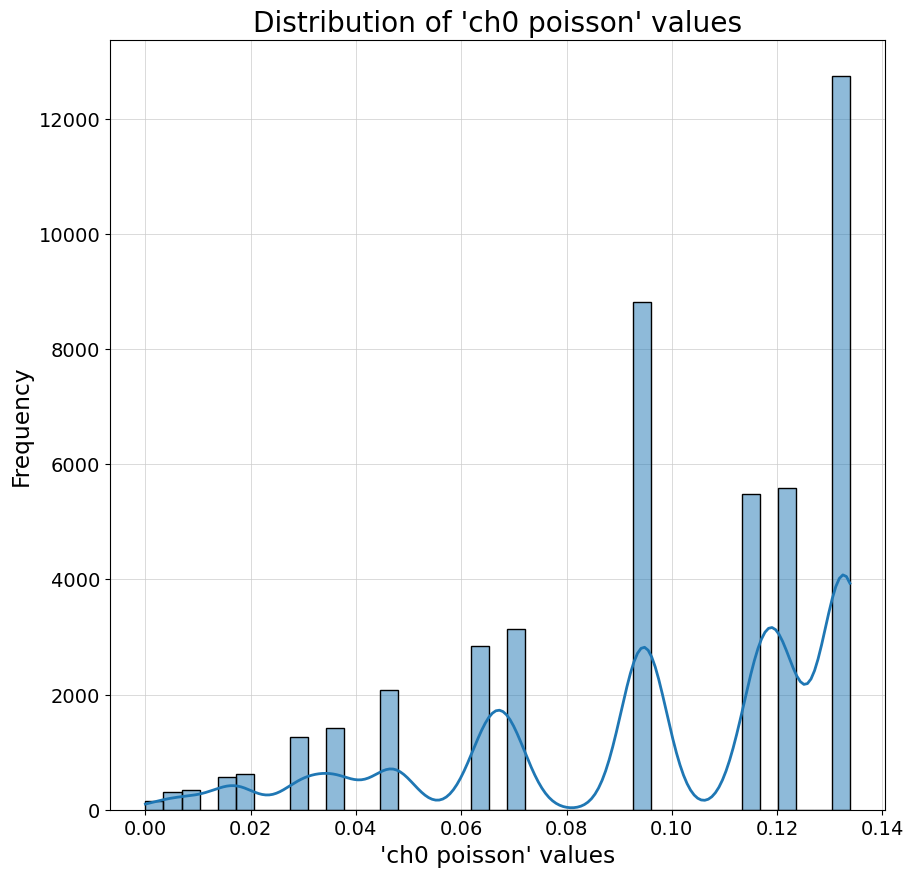

(0.9998566182637237, 0.0)

In [42]:
import seaborn as sns
import scipy.stats as stats
# Load the new data from the updated pickle file
updated_data_path = "../../data/Run7/cosmics-endofrun/reduced_with_poisson_with_intervals.p"
df7_updated = pickle.load(open(updated_data_path, "rb"))[0]

ch0_poisson_values = df7_updated['ch0 poisson'].dropna()

# Perform Kolmogorov-Smirnov test for Poisson distribution
ks_stat, ks_p_value = stats.kstest(ch0_poisson_values, 'poisson', args=(lambda_poisson,))

# Create a histogram to visualize the distribution of 'ch0 poisson'
fig, ax = plt.subplots()
sns.histplot(ch0_poisson_values,kde=True, ax=ax)

# Set plot details
ax.set_title("Distribution of 'ch0 poisson' values")
ax.set_xlabel("'ch0 poisson' values")
ax.set_ylabel("Frequency")

plt.show()  # Display the histogram with KDE

# Return Kolmogorov-Smirnov test results
ks_stat, ks_p_value